In [1]:
import os
import numpy as np
from numpy import load, savez
import utils
import copy
import matplotlib.pyplot as plt
import nibabel as nib

from skimage.util import random_noise
from itertools import repeat
import multiprocessing
from multiprocessing import Pool

In [108]:
### reload specific modules
import importlib
importlib.reload(utils)

<module 'utils' from '/home/ashwani/Desktop/Denoising-BrainTumor/notebooks/utils.py'>

range(42, 104)
(50, 240, 240, 1)


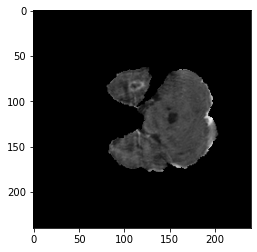

In [98]:
test_file1 = nib.load("../test_files/image_3d/testimg_3d_seg.nii").get_fdata(dtype=np.float32)
t1ce = nib.load("../test_files/image_3d/testimg_3d_t1ce.nii").get_fdata(dtype=np.float32)
res  = utils.findminmaxidx(test_file1, 900)
print(res)
input_dataset = np.rollaxis(t1ce, 2,0).reshape(155,240, 240, 1)[res][0:50]
print(input_dataset.shape)
input_dataset = (input_dataset - np.min(input_dataset))/(np.max(input_dataset) - np.min(input_dataset))
np.save("input_dataset_50.npy", input_dataset)
plt.imshow(input_dataset[0], cmap="gray")

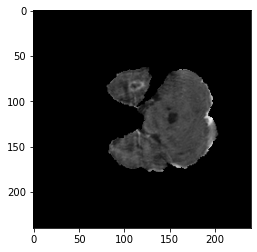

In [99]:
input_dataset = load("input_dataset_50.npy")
input_dataset.shape
plt.imshow(input_dataset[0], cmap="gray")

In [100]:
utils.plotExamples("./inputset", utils.getExamples(5, input_dataset), ["image"])

5
[Errno 17] File exists: './inputset'
./inputset/file1.png
./inputset/file2.png
./inputset/file3.png
./inputset/file4.png
./inputset/file5.png


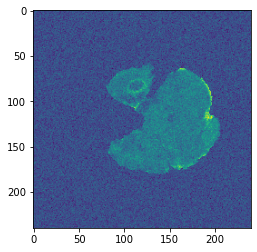

In [6]:
plt.imshow(utils.gaussian_wholedataset(input_dataset, 0, 0.07)[2])

In [8]:
inputs = [ (0,0.1), (0, 0.1)]



def starmapshit(fn, input_dataset, inputs):
    args_iter = repeat(input_dataset)
    try:
        cpu_count = multiprocessing.cpu_count()
        pool = multiprocessing.Pool(processes = cpu_count) 
        kwargs_iter = [dict(mean=i, var=j) for i, j in inputs]
        kwargs_iter = repeat(dict(mean=1, var= 1))
        print(kwargs_iter)
        branches = utils.starmap_with_kwargs(pool, fn , args_iter, kwargs_iter)
    finally:
        pool.close()
        pool.join()
    return branches

a = starmapshit(gaussian_wholedataset2, input_dataset[0:1], inputs)

NameError: name 'gaussian_wholedataset2' is not defined

In [101]:
def gaussian_wholedataset_ski(dataset,mean,var):
    data = copy.deepcopy(dataset)
    for i in range(data.shape[0]):
        data[i,:,:,:] = random_noise(data[i,:,:,:], mode="gaussian", seed=None, clip = True, mean=mean, var = var)
    return data

In [102]:
gauss_dataset1 = utils.gaussian_wholedataset(input_dataset, 0, 0.05)

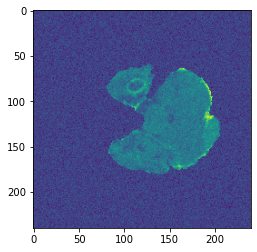

In [103]:
plt.imshow(gauss_dataset1[2])

In [104]:
gauss_dataset1.max()

1.065795

In [157]:
from skimage.filters import gabor
from skimage.restoration import denoise_nl_means, estimate_sigma, denoise_tv_chambolle, denoise_bilateral,denoise_wavelet
import cv2
from skimage.filters import median

from tqdm import tqdm

In [163]:
def nlm_wholedataset(noised_dataset):
    nlm_dataset = copy.deepcopy(noised_dataset)
    # estimate the noise standard deviation from the noisy image
    sigma_est = np.mean(estimate_sigma(noised_dataset[0, :, :, :], channel_axis=-1))
    print("Sigma Val:", sigma_est)
    for i in tqdm(range(noised_dataset.shape[0])):
        patch_kw = dict(patch_size=5,      # 5x5 patches
                patch_distance=6,  # 13x13 search area
                channel_axis=-1)
        nlm_dataset[i] = denoise_nl_means(noised_dataset[i,:,:,:], h=1.15 * sigma_est, fast_mode=True, **patch_kw).reshape(240, 240, 1)
    return nlm_dataset


def median_wholedataset(noised_dataset):
    median_wholedata = copy.deepcopy(noised_dataset)
    for i in tqdm(range(noised_dataset.shape[0])):
        median_wholedata[i] = median(noised_dataset[i,:,:,:][:,:,0], np.ones((3, 3))).reshape(240,240,1)
    return median_wholedata

def totalvar_wholedataset(noised_dataset):
    totalvar_wholedata = copy.deepcopy(noised_dataset)
    # estimate the noise standard deviation from the noisy image
    sigma_est = np.mean(estimate_sigma(noised_dataset[0, :, :, :], channel_axis=-1))
    for i in tqdm(range(noised_dataset.shape[0])):
        totalvar_wholedata[i] = denoise_tv_chambolle(noised_dataset[i,:,:,:][:,:,0], weight=0.1, channel_axis=-1).reshape(240,240,1)
    return totalvar_wholedata


def bilateral2_wholedataset(noised_dataset):
    bilateral2_wholedata = copy.deepcopy(noised_dataset)
    for i in tqdm(range(noised_dataset.shape[0])):
        bilateral2_wholedata[i] = denoise_bilateral(noised_dataset[i,:,:,:], sigma_color=0.05, sigma_spatial=15,channel_axis=-1).reshape(240,240,1)
    return bilateral2_wholedata


def wavelet_wholedataset(noised_dataset):
    wavelet_wholedata = copy.deepcopy(noised_dataset)
    for i in tqdm(range(noised_dataset.shape[0])):
        wavelet_wholedata[i] = denoise_wavelet(noised_dataset[i,:,:,:][:,:,0], channel_axis=-1, rescale_sigma=True).reshape(240,240,1)
    return wavelet_wholedata

# d = nlm_wholedataset(gauss_dataset1)
# d2 = median_wholedataset(gauss_dataset1)
# d3 = totalvar_wholedataset(gauss_dataset1)
d4 = bilateral2_wholedataset(gauss_dataset1)
d5 = wavelet_wholedataset(gaussdataset1)

100%|█████████████████████████████████| 50/50 [04:14<00:00,  5.09s/it]


NameError: name 'gaussdataset1' is not defined

In [151]:
gauss_dataset1[0][:,:,0].shape

(240, 240)

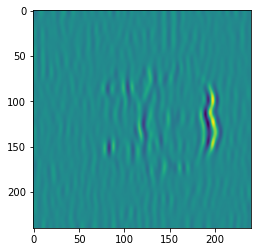

In [152]:
plt.imshow(img)

In [166]:
# a1 = utils.AnisotropicFilter_wholedataset(gauss_dataset1, 50, 100, 0.004, 1)
# a1 = utils.GaussianFilter_wholedataset(gauss_dataset1, 2)
# a1 = utils.BilateralFilter_wholedataset(gauss_dataset1, 15, -1)
# a1 = utils.WienerFilter_wholedataset(gauss_dataset1)
# a1 = nlm_wholedataset(gauss_dataset1)
# a1 = median_wholedataset(gauss_dataset1)
# a1 = bilateral2_wholedataset(gauss_dataset1) # 27.30, 0.79, 0.001
# a1 = totalvar_wholedataset(gauss_dataset1) # 31.91,0.89, 0.0003
#  a1 = wavelet_wholedataset(gauss_dataset1) # 30.06, 0.86, 0.0005

print(a1.shape)
val1 = utils.psnr_wholedataset(input_dataset, a1)
val2 = utils.ssim_wholedataset(input_dataset, a1)
val3 = utils.mse_wholedataset(input_dataset, a1)
print(val1)
print(val2)
print(val3)

100%|█████████████████████████████████| 50/50 [00:13<00:00,  3.63it/s]


(50, 240, 240, 1)
30.062938451079837
0.8627694764347529
0.0005535518884312838


In [170]:
rician_dataset = utils.rician_wholedataset(input_dataset, 5, 3, 240*240)

In [171]:
a1 = utils.AnisotropicFilter_wholedataset(rician_dataset, 50, 100, 0.004, 1)
a2 = utils.GaussianFilter_wholedataset(rician_dataset, 2)
a3 = utils.BilateralFilter_wholedataset(rician_dataset, 15, -1)
a4 = utils.WienerFilter_wholedataset(rician_dataset)
a5 = nlm_wholedataset(rician_dataset)
a6 = median_wholedataset(rician_dataset)
# a7 = bilateral2_wholedataset(rician_dataset) # 27.30, 0.79, 0.001
a7 = totalvar_wholedataset(rician_dataset) # 31.91,0.89, 0.0003
a8 = wavelet_wholedataset(rician_dataset) # 30.06, 0.86, 0.0005


Sigma Val: 0.010724334821130015


100%|█████████████████████████████████| 50/50 [00:11<00:00,  4.33it/s]


In [181]:
for i in range(1, 9):
    name =  eval(f"a{i}")
    psnr = utils.psnr_wholedataset(input_dataset, name)
    ssim = utils.ssim_wholedataset(input_dataset, name)
    mse = utils.mse_wholedataset(input_dataset, name)
    print(f"Name: a{i}", " PSNR: ", psnr, ", SSIM:", ssim, ", MSE: ", mse)

# print(a1.shape)
# val1 = utils.psnr_wholedataset(input_dataset, a1)
# val2 = utils.ssim_wholedataset(input_dataset, a1)
# val3 = utils.mse_wholedataset(input_dataset, a1)

# for i in range(1,9):
# print(val1)
# print(val2)
# print(val3)

Name: a1  PSNR:  22.840483169389643 , SSIM: 0.5860439816468876 , MSE:  0.0037755939651142488
Name: a2  PSNR:  22.51546714777256 , SSIM: 0.5567850782503769 , MSE:  0.003909389080248547
Name: a3  PSNR:  23.52458752950954 , SSIM: 0.6171495326600175 , MSE:  0.0031280548663444405
Name: a4  PSNR:  22.21416776328715 , SSIM: 0.5526085012290628 , MSE:  0.004194051632856421
Name: a5  PSNR:  22.851511068050392 , SSIM: 0.5877752962294795 , MSE:  0.0038001995315563183
Name: a6  PSNR:  22.82378703736581 , SSIM: 0.5887761912455014 , MSE:  0.0037852724863948867
Name: a7  PSNR:  22.861350942435152 , SSIM: 0.5719928386024153 , MSE:  0.0037457236784577044
Name: a8  PSNR:  22.818315357225238 , SSIM: 0.58362918253981 , MSE:  0.0038159039389178894


In [195]:
rayleigh_dataset = utils.rayleigh_wholedataset(input_dataset, 0.001)
a1 = utils.AnisotropicFilter_wholedataset(rayleigh_dataset, 50, 100, 0.01, 1)
val1 = utils.psnr_wholedataset(input_dataset, a1)
val2 = utils.ssim_wholedataset(input_dataset, a1)
val3 = utils.mse_wholedataset(input_dataset, a1)
print(val1)
print(val2)
print(val3)

25.53874270325877
0.9696963811145922
0.0025557126774289098


In [196]:
rayleigh_dataset = utils.rayleigh_wholedataset(input_dataset,0.001)
a1 = utils.AnisotropicFilter_wholedataset(rayleigh_dataset, 50, 100, 0.004, 1)
a2 = utils.BilateralFilter_wholedataset(rayleigh_dataset, 15, -1)
a3 = utils.WienerFilter_wholedataset(rayleigh_dataset)
a4 = utils.GaussianFilter_wholedataset(rayleigh_dataset, 2)
a5 = nlm_wholedataset(rayleigh_dataset)
a6 = median_wholedataset(rayleigh_dataset)
a7 = bilateral2_wholedataset(rayleigh_dataset) # 27.30, 0.79, 0.001
a8 = totalvar_wholedataset(rayleigh_dataset) # 31.91,0.89, 0.0003
a9 = wavelet_wholedataset(rayleigh_dataset) # 30.06, 0.86, 0.0005


Sigma Val: 4.2332507857890725e-06


100%|█████████████████████████████████| 50/50 [00:11<00:00,  4.39it/s]


In [197]:
for i in range(1, 9):
    name =  eval(f"a{i}")
    psnr = utils.psnr_wholedataset(input_dataset, name)
    ssim = utils.ssim_wholedataset(input_dataset, name)
    mse = utils.mse_wholedataset(input_dataset, name)
    print(f"Name: a{i}", " PSNR: ", psnr, ", SSIM:", ssim, ", MSE: ", mse)


Name: a1  PSNR:  25.821924692542353 , SSIM: 0.9786542033076813 , MSE:  0.0025102777285477685
Name: a2  PSNR:  26.036326027819953 , SSIM: 0.9177440158046967 , MSE:  0.0020928775876608787
Name: a3  PSNR:  24.485220288339775 , SSIM: 0.8795106905134658 , MSE:  0.002950690029900157
Name: a4  PSNR:  25.001888429194793 , SSIM: 0.9410238871260528 , MSE:  0.0026563954689717783
Name: a5  PSNR:  25.80208826471408 , SSIM: 0.9787992399289416 , MSE:  0.0025589479489175394
Name: a6  PSNR:  25.60925028888097 , SSIM: 0.9734187013432716 , MSE:  0.002564045023769028
Name: a7  PSNR:  25.879092034954326 , SSIM: 0.9766372266230587 , MSE:  0.0024432641693565146
Name: a8  PSNR:  25.775749718102112 , SSIM: 0.964035472528352 , MSE:  0.0024981298827743467


In [23]:
utils.plotExamples("./results/",utils.getExamples(5,input_dataset, gauss_dataset1, a1), ["image", "gauss_dataset1", "a1"])

5
[Errno 17] File exists: './results/'
./results//file1.png
./results//file2.png
./results//file3.png
./results//file4.png
./results//file5.png


In [110]:
np.save("gauss_0_0.01.npy", gauss_dataset1)
np.save("gauss_0_0.1.npy", gauss_dataset2)
np.save("gauss_0.1_0.01.npy", gauss_dataset3)

In [111]:
input_dataset.shape

(72, 240, 240, 1)

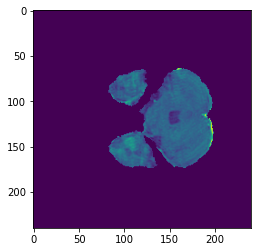

In [112]:
plt.imshow(input_dataset[3])

In [128]:
utils.plotExamples(utils.getExamples(5,input_dataset, gauss_dataset1, gauss_dataset2, gauss_dataset3), ["image", "gauss_dataset1", "gauss_dataset2", "gauss_dataset3"])

5
./file1.png
./file2.png
./file3.png
./file4.png
./file5.png


In [129]:
 gauss_data1.shape

NameError: name 'gauss_data1' is not defined

In [143]:
a1 = utils.AnisotropicFilter_wholedataset(gauss_dataset1, 50, 100, 0.01, 1)
a2 = utils.AnisotropicFilter_wholedataset(gauss_dataset2, 50, 100, 0.1, 1)
a3 = utils.AnisotropicFilter_wholedataset(gauss_dataset3, 50, 100, 0.4, 1)

In [144]:
utils.plotExamples(utils.getExamples(5,input_dataset, gauss_dataset1, a1), ["image", "gauss_dataset1", "a1"])

5
./file1.png
./file2.png
./file3.png
./file4.png
./file5.png


In [145]:
val1 = utils.psnr_wholedataset(input_dataset, a1)
val2 = utils.psnr_wholedataset(input_dataset, a2)
val3 = utils.psnr_wholedataset(input_dataset, a3)
print("Val 1:", val1)
print("Val 2:", val2)
print("Val 3:", val3)

Val 1: 27.987436979881505
Val 2: 13.29095223792486
Val 3: -35.48526786317505
